In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from collections import defaultdict
from datetime import datetime
from marketing_attribution_models import MAM
import warnings
warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)

import google.cloud.bigquery as bq
client = bq.Client.from_service_account_json("marius_arlauskas.json")

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv('cleaned_df.csv', index_col=0)

In [3]:
df.columns = ['cookie', 'path', 'timestamps', 'conversion_value', 'conversion']

In [4]:
df['path'] = df['path'].apply(eval)
df['timestamps'] = df['timestamps'].apply(eval)

In [5]:
def time_from(x):
    rez = []
    for i in range(len(x)):
        first = x[i]
        last = x[-1]
        first = datetime.strptime(first.split('+')[0], "%Y-%m-%d %H:%M:%S")
        last = datetime.strptime(last.split('+')[0], "%Y-%m-%d %H:%M:%S")
        rez.append((last - first).total_seconds())
    return np.array(rez) / 3600

In [6]:
def group_mob(x):
    new = []
    for ch in x:
        if 'mob' in ch:
            new.append('mobile')
        else:
            new.append(ch)
    return new
df['path'] = df['path'].apply(group_mob)

In [8]:
df['path'] = df['path'].apply(group_mob)

In [9]:
df['time_till_conv_agg'] = df['timestamps'].apply(time_from)

In [10]:
df['cookie'] = df['cookie'].astype(str)

In [11]:
df['conversion'] = df['conversion'].apply(bool)

In [12]:
def joiner(x):
    return ' > '.join(str(v) for v in x)
df['path'] = df['path'].apply(joiner)
df['time_till_conv_agg'] = df['time_till_conv_agg'].apply(list).apply(joiner)

In [13]:
attributions = MAM(df, 
                   time_till_conv_colname='time_till_conv_agg',
                   conversion_value='conversion_value',
                   channels_colname='path',
                   journey_with_conv_colname='conversion',
                   )

In [14]:
attr_first = attributions.attribution_first_click()
attr_last = attributions.attribution_last_click()

In [15]:
attr_time_decay = attributions.attribution_time_decay(decay_over_time=0.5, frequency=8)

In [16]:
attr_markov = attributions.attribution_markov(transition_to_same_state=True)

In [17]:
attributions.as_pd_dataframe()

,channels_agg,converted_agg,conversion_value,time_till_conv_agg,attribution_first_click_heuristic,attribution_last_click_heuristic,attribution_time_decay0.5_freq8_heuristic,attribution_markov_same_state_algorithmic
0,brand,False,0.000,0.0,0.0,0.0,0.0,1.0
1,organic,False,0.000,0.0,0.0,0.0,0.0,1.0
2,organic,False,0.000,0.0,0.0,0.0,0.0,1.0
3,affiliates_vps,False,0.000,0.0,0.0,0.0,0.0,1.0
4,ppc,False,0.000,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
3007266,organic,False,0.000,0.0,0.0,0.0,0.0,1.0
3007267,brand,False,0.000,0.0,0.0,0.0,0.0,1.0
3007269,organic,True,59.760,0.0,59.76,59.76,59.76,1.0
3007270,other > other > other > other,False,0.000,111.94 > 84.96444444444444 > 3.231111111111111...,0.0 > 0.0 > 0.0 > 0.0,0.0 > 0.0 > 0.0 > 0.0,0.0 > 0.0 > 0.0 > 0.0,0.25 > 0.25 > 0.25 > 0.25


<AxesSubplot:xlabel='channels', ylabel='value'>

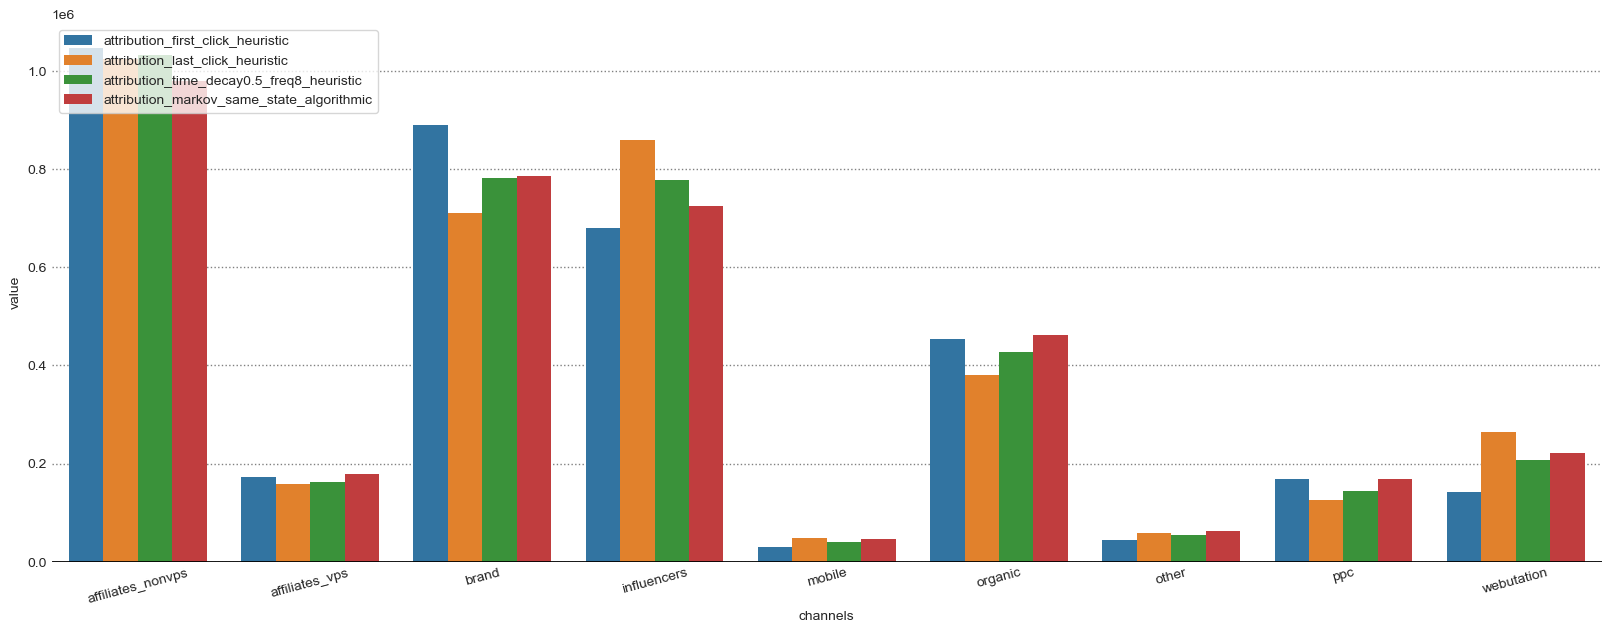

In [18]:
attributions.plot()

In [22]:
attr_first[1]

channels
affiliates_nonvps   1045263.710
affiliates_vps       172632.150
brand                889289.730
influencers          678829.530
mobile                29967.090
organic              454026.510
other                 44996.270
ppc                  169451.540
webutation           142274.390
Name: value, dtype: float64

In [27]:
attr_last[1]

,channels,attribution_last_click_heuristic
0,affiliates_nonvps,1024791.990
1,affiliates_vps,158694.140
2,brand,710357.380
3,influencers,859145.870
4,mobile,48076.720
5,organic,379643.710
6,other,57920.390
7,ppc,124797.800
8,webutation,263302.920


In [37]:
attr_markov[1].sort_values(by='channels')

,channels,attribution_markov_same_state_algorithmic
8,affiliates_nonvps,979341.836
5,affiliates_vps,177922.307
1,brand,786514.287
7,influencers,723881.986
2,mobile,46255.259
4,organic,460905.886
6,other,62301.383
0,ppc,168230.548
3,webutation,221377.428


In [29]:
attr_time_decay[1]

,channels,attribution_time_decay0.5_freq8_heuristic
0,affiliates_nonvps,1031973.469
1,affiliates_vps,163219.200
2,brand,782232.288
3,influencers,776401.229
4,mobile,39493.916
5,organic,426628.377
6,other,55494.488
7,ppc,144594.599
8,webutation,206693.355
